# Parcial 1 - Titanic Dataset (OPTIMIZADO)
## Predicción de Supervivencia con Red Neuronal

**Curso:** Modelos de Pronóstico  
**Fecha:** 2 de Octubre, 2025

**Objetivo:** Predecir supervivencia con Red Neuronal optimizada (F1 > 0.80)

## 1. Importar Librerías

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

np.random.seed(42)
plt.style.use('default')
sns.set_palette('Set2')

print("Librerias importadas")

Librerias importadas


## 2. Cargar Datos

In [59]:
train = pd.read_csv('./Titanic/train.csv')
test = pd.read_csv('./Titanic/test.csv')

print(f"Train: {train.shape}")
print(f"Test: {test.shape}")

test_passenger_ids = test['PassengerId'].copy()

train.head()

Train: (891, 12)
Test: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 3. Exploración Rápida

In [60]:
print("="*60)
print("INFORMACION")
print("="*60)
train.info()

print("\n" + "="*60)
print("VALORES NULOS")
print("="*60)
print(train.isnull().sum())

INFORMACION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

VALORES NULOS
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked

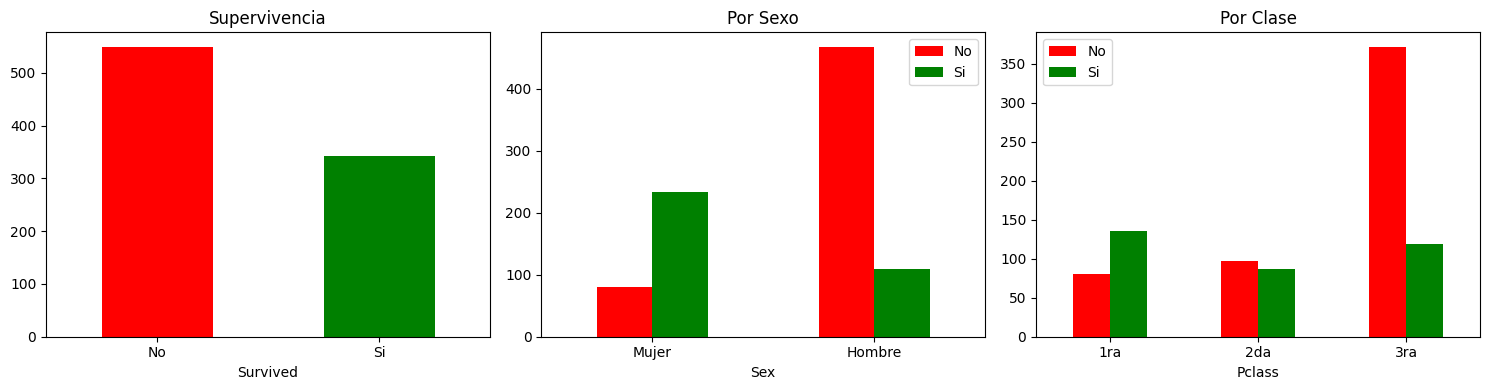

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

train['Survived'].value_counts().plot(kind='bar', ax=axes[0], color=['red', 'green'])
axes[0].set_title('Supervivencia')
axes[0].set_xticklabels(['No', 'Si'], rotation=0)

pd.crosstab(train['Sex'], train['Survived']).plot(kind='bar', ax=axes[1], color=['red', 'green'])
axes[1].set_title('Por Sexo')
axes[1].set_xticklabels(['Mujer', 'Hombre'], rotation=0)
axes[1].legend(['No', 'Si'])

pd.crosstab(train['Pclass'], train['Survived']).plot(kind='bar', ax=axes[2], color=['red', 'green'])
axes[2].set_title('Por Clase')
axes[2].set_xticklabels(['1ra', '2da', '3ra'], rotation=0)
axes[2].legend(['No', 'Si'])

plt.tight_layout()
plt.show()

## 4. Preprocesamiento OPTIMIZADO (CON ALINEACION)

In [62]:
def preprocesar_base(df):
    """Preprocesamiento sin one-hot encoding"""
    df = df.copy()
    
    # Feature Engineering basico
    df['TamanoFamilia'] = df['SibSp'] + df['Parch'] + 1
    df['ViajaS olo'] = (df['TamanoFamilia'] == 1).astype(int)
    
    # Titulo
    df['Titulo'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Titulo'] = df['Titulo'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 
                                           'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Raro')
    df['Titulo'] = df['Titulo'].replace('Mlle', 'Miss')
    df['Titulo'] = df['Titulo'].replace('Ms', 'Miss')
    df['Titulo'] = df['Titulo'].replace('Mme', 'Mrs')
    
    df['TieneCabina'] = df['Cabin'].notna().astype(int)
    
    # Deck
    df['Deck'] = df['Cabin'].str[0]
    df['Deck'] = df['Deck'].fillna('U')
    
    # Imputacion
    for pclass in df['Pclass'].unique():
        for sex in df['Sex'].unique():
            mask = (df['Pclass'] == pclass) & (df['Sex'] == sex)
            mediana = df[mask]['Age'].median()
            df.loc[mask & df['Age'].isna(), 'Age'] = mediana
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    
    # Feature Engineering avanzado
    df['EsNino'] = (df['Age'] < 12).astype(int)
    df['EsJoven'] = ((df['Age'] >= 12) & (df['Age'] < 20)).astype(int)
    df['EsAdulto'] = ((df['Age'] >= 20) & (df['Age'] < 60)).astype(int)
    df['EsAnciano'] = (df['Age'] >= 60).astype(int)
    
    df['FamiliaPequena'] = (df['TamanoFamilia'] <= 1).astype(int)
    df['FamiliaMediana'] = ((df['TamanoFamilia'] > 1) & (df['TamanoFamilia'] <= 4)).astype(int)
    df['FamiliaGrande'] = (df['TamanoFamilia'] > 4).astype(int)
    
    df['TarifaPorPersona'] = df['Fare'] / df['TamanoFamilia']
    
    df['TarifaBaja'] = (df['Fare'] <= 7.91).astype(int)
    df['TarifaMedia'] = ((df['Fare'] > 7.91) & (df['Fare'] <= 14.454)).astype(int)
    df['TarifaMediaAlta'] = ((df['Fare'] > 14.454) & (df['Fare'] <= 31)).astype(int)
    df['TarifaAlta'] = (df['Fare'] > 31).astype(int)
    
    df['Sexo_Numerico'] = (df['Sex'] == 'male').astype(int)
    df['Sexo_x_Clase'] = df['Sexo_Numerico'] * df['Pclass']
    df['Edad_x_Clase'] = df['Age'] * df['Pclass']
    
    df['Mujer_Primera'] = ((df['Sex'] == 'female') & (df['Pclass'] == 1)).astype(int)
    df['Hombre_Tercera'] = ((df['Sex'] == 'male') & (df['Pclass'] == 3)).astype(int)
    
    return df

print("Paso 1: Preprocesamiento base...")
train_prep = preprocesar_base(train)
test_prep = preprocesar_base(test)
print("Completado")

Paso 1: Preprocesamiento base...
Completado


In [63]:
# Aplicar one-hot encoding de forma ALINEADA
print("Paso 2: One-hot encoding alineado...")

# Embarked
embarked_train = pd.get_dummies(train_prep['Embarked'], prefix='Puerto')
embarked_test = pd.get_dummies(test_prep['Embarked'], prefix='Puerto')

# Titulo
titulo_train = pd.get_dummies(train_prep['Titulo'], prefix='Titulo')
titulo_test = pd.get_dummies(test_prep['Titulo'], prefix='Titulo')

# Deck
deck_train = pd.get_dummies(train_prep['Deck'], prefix='Deck')
deck_test = pd.get_dummies(test_prep['Deck'], prefix='Deck')

# Alinear columnas: asegurar que test tenga todas las columnas de train
for col in embarked_train.columns:
    if col not in embarked_test.columns:
        embarked_test[col] = 0
        
for col in titulo_train.columns:
    if col not in titulo_test.columns:
        titulo_test[col] = 0
        
for col in deck_train.columns:
    if col not in deck_test.columns:
        deck_test[col] = 0

# Alinear en el otro sentido: asegurar que train tenga todas las columnas de test
for col in embarked_test.columns:
    if col not in embarked_train.columns:
        embarked_train[col] = 0
        
for col in titulo_test.columns:
    if col not in titulo_train.columns:
        titulo_train[col] = 0
        
for col in deck_test.columns:
    if col not in deck_train.columns:
        deck_train[col] = 0

# Reordenar columnas para que coincidan
embarked_test = embarked_test[embarked_train.columns]
titulo_test = titulo_test[titulo_train.columns]
deck_test = deck_test[deck_train.columns]

# Concatenar
train_prep = pd.concat([train_prep, embarked_train, titulo_train, deck_train], axis=1)
test_prep = pd.concat([test_prep, embarked_test, titulo_test, deck_test], axis=1)

print("Completado")
print(f"Train: {train_prep.shape}")
print(f"Test: {test_prep.shape}")
print(f"Valores nulos train: {train_prep.isnull().sum().sum()}")
print(f"Valores nulos test: {test_prep.isnull().sum().sum()}")

Paso 2: One-hot encoding alineado...
Completado
Train: (891, 51)
Test: (418, 50)
Valores nulos train: 687
Valores nulos test: 327


## 5. Preparar Datos

In [64]:
# Seleccionar features
features = ['Pclass', 'Sexo_Numerico', 'Age', 'SibSp', 'Parch', 'Fare',
            'TamanoFamilia', 'ViajaS olo', 'TieneCabina',
            'EsNino', 'EsJoven', 'EsAdulto', 'EsAnciano',
            'FamiliaPequena', 'FamiliaMediana', 'FamiliaGrande',
            'TarifaPorPersona', 'TarifaBaja', 'TarifaMedia', 'TarifaMediaAlta', 'TarifaAlta',
            'Sexo_x_Clase', 'Edad_x_Clase', 'Mujer_Primera', 'Hombre_Tercera'] + \
           [col for col in train_prep.columns if col.startswith('Puerto_')] + \
           [col for col in train_prep.columns if col.startswith('Titulo_')] + \
           [col for col in train_prep.columns if col.startswith('Deck_')]

X = train_prep[features]
y = train_prep['Survived']
X_test = test_prep[features]

print(f"Features: {len(features)}")
print(f"X_train: {X.shape}")
print(f"X_test: {X_test.shape}")
print(f"\nPrimeras 10 features:")
for i, f in enumerate(features[:10], 1):
    print(f"  {i}. {f}")
print(f"  ... y {len(features)-10} mas")

Features: 42
X_train: (891, 42)
X_test: (418, 42)

Primeras 10 features:
  1. Pclass
  2. Sexo_Numerico
  3. Age
  4. SibSp
  5. Parch
  6. Fare
  7. TamanoFamilia
  8. ViajaS olo
  9. TieneCabina
  10. EsNino
  ... y 32 mas


In [65]:
# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape[0]} muestras")
print(f"Val: {X_val.shape[0]} muestras")

Train: 712 muestras
Val: 179 muestras


## 6. Modelos de Red Neuronal

In [66]:
configuraciones = {
    'Modelo 1': {
        'hidden_layer_sizes': (100, 50, 25),
        'activation': 'relu',
        'solver': 'adam',
        'alpha': 0.0001,
        'learning_rate': 'adaptive',
        'learning_rate_init': 0.001,
        'max_iter': 1000,
        'random_state': 42
    },
    'Modelo 2': {
        'hidden_layer_sizes': (150, 100, 50, 25),
        'activation': 'relu',
        'solver': 'adam',
        'alpha': 0.0001,
        'learning_rate': 'adaptive',
        'learning_rate_init': 0.001,
        'max_iter': 1000,
        'random_state': 42
    },
    'Modelo 3': {
        'hidden_layer_sizes': (200, 150, 100, 50, 25),
        'activation': 'relu',
        'solver': 'adam',
        'alpha': 0.00005,
        'learning_rate': 'adaptive',
        'learning_rate_init': 0.001,
        'max_iter': 1000,
        'random_state': 42
    }
}

print("Configuraciones:")
for nombre, config in configuraciones.items():
    print(f"\n{nombre}: {config['hidden_layer_sizes']}")

Configuraciones:

Modelo 1: (100, 50, 25)

Modelo 2: (150, 100, 50, 25)

Modelo 3: (200, 150, 100, 50, 25)


In [67]:
modelos = {}
resultados = {}

for nombre, config in configuraciones.items():
    print(f"\n{'='*60}")
    print(f"Entrenando: {nombre}")
    print(f"{'='*60}")
    
    modelo = MLPClassifier(**config, early_stopping=True, validation_fraction=0.1, 
                           n_iter_no_change=20, verbose=False)
    modelo.fit(X_train, y_train)
    
    y_pred_val = modelo.predict(X_val)
    
    acc = accuracy_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val)
    f1_0 = f1_score(y_val, y_pred_val, pos_label=0)
    f1_1 = f1_score(y_val, y_pred_val, pos_label=1)
    
    modelos[nombre] = modelo
    resultados[nombre] = {
        'Accuracy': acc,
        'F1-Score': f1,
        'F1-Clase-0': f1_0,
        'F1-Clase-1': f1_1
    }
    
    print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | F1-Clase-1: {f1_1:.4f}")

print(f"\n{'='*60}")
print("ENTRENAMIENTO COMPLETADO")
print(f"{'='*60}")


Entrenando: Modelo 1
Accuracy: 0.7989 | F1: 0.7429 | F1-Clase-1: 0.7429

Entrenando: Modelo 2
Accuracy: 0.8156 | F1: 0.7442 | F1-Clase-1: 0.7442

Entrenando: Modelo 3
Accuracy: 0.7877 | F1: 0.7031 | F1-Clase-1: 0.7031

ENTRENAMIENTO COMPLETADO


## 7. Comparación

In [68]:
df_resultados = pd.DataFrame(resultados).T.round(4)

print("\n" + "="*80)
print("COMPARACION DE MODELOS")
print("="*80)
print(df_resultados)

mejor = df_resultados['F1-Clase-1'].idxmax()
mejor_f1 = df_resultados.loc[mejor, 'F1-Clase-1']

print(f"\n{'='*80}")
print(f"MEJOR: {mejor}")
print(f"F1-Clase-1: {mejor_f1:.4f}")
print(f"Estado: {'SUPERA 0.7' if mejor_f1 > 0.7 else 'NO supera'}")
if mejor_f1 > 0.8:
    print("EXCELENTE: Supera 0.8!")
print(f"{'='*80}")


COMPARACION DE MODELOS
          Accuracy  F1-Score  F1-Clase-0  F1-Clase-1
Modelo 1    0.7989    0.7429      0.8349      0.7429
Modelo 2    0.8156    0.7442      0.8559      0.7442
Modelo 3    0.7877    0.7031      0.8348      0.7031

MEJOR: Modelo 2
F1-Clase-1: 0.7442
Estado: SUPERA 0.7


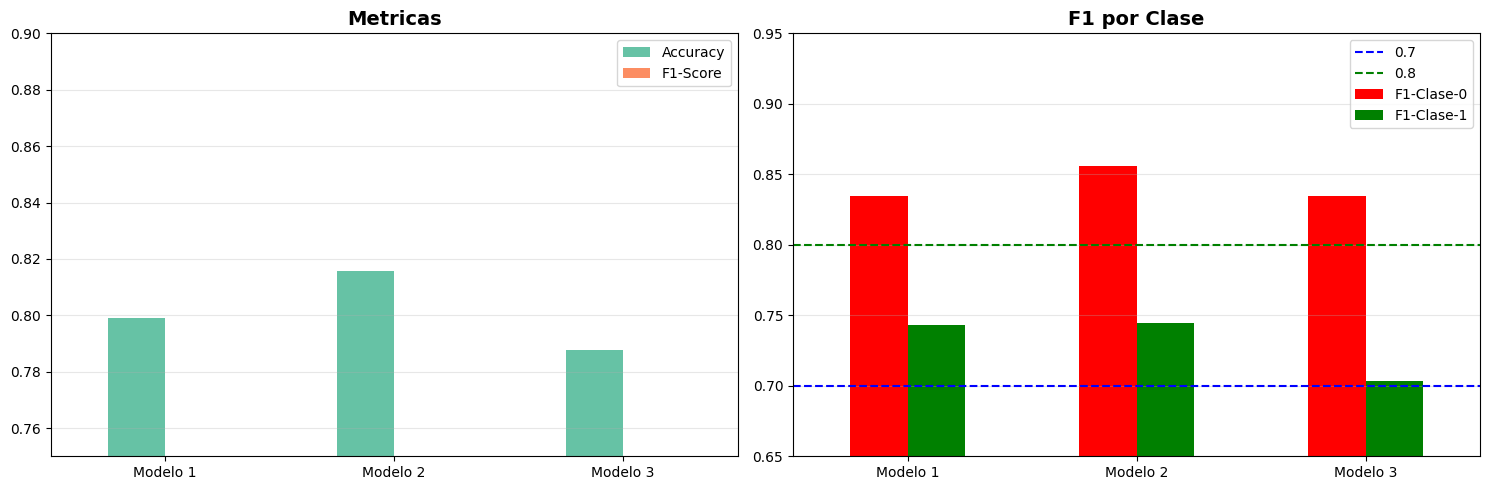

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

df_resultados[['Accuracy', 'F1-Score']].plot(kind='bar', ax=axes[0], rot=0)
axes[0].set_title('Metricas', fontsize=14, fontweight='bold')
axes[0].set_ylim([0.75, 0.90])
axes[0].grid(axis='y', alpha=0.3)

df_resultados[['F1-Clase-0', 'F1-Clase-1']].plot(kind='bar', ax=axes[1], rot=0, color=['red', 'green'])
axes[1].set_title('F1 por Clase', fontsize=14, fontweight='bold')
axes[1].axhline(y=0.7, color='blue', linestyle='--', label='0.7')
axes[1].axhline(y=0.8, color='green', linestyle='--', label='0.8')
axes[1].set_ylim([0.65, 0.95])
axes[1].grid(axis='y', alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

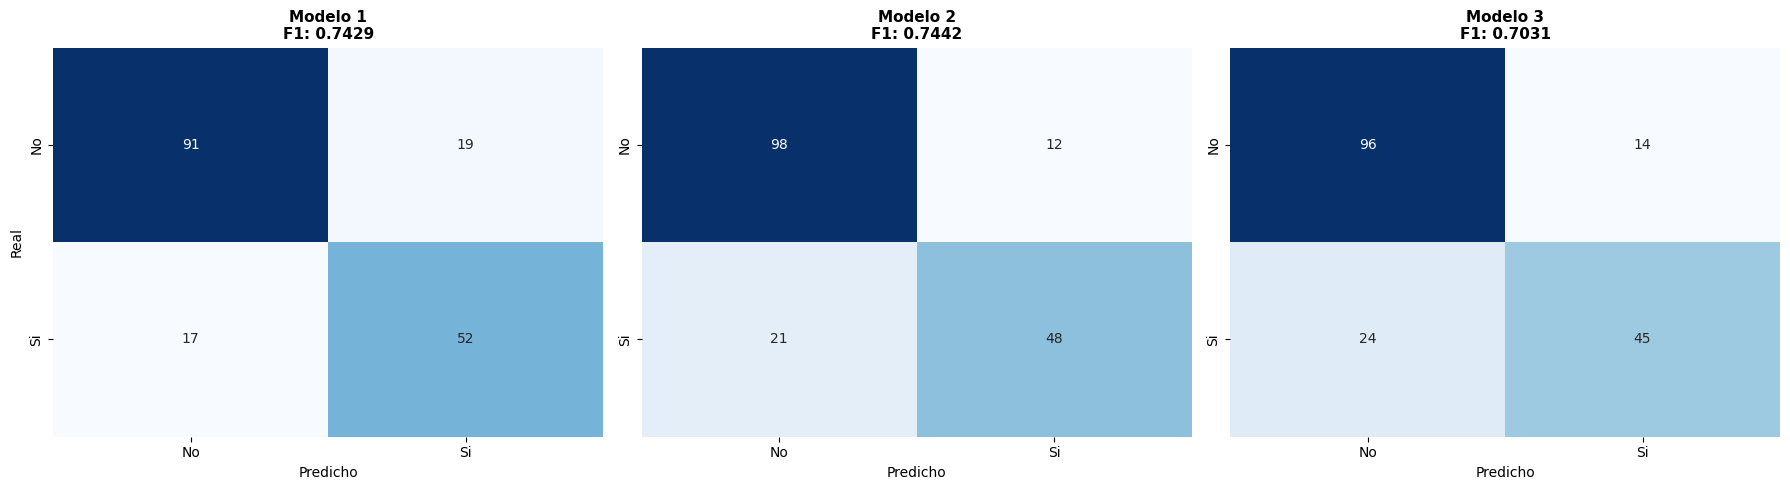

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (nombre, modelo) in enumerate(modelos.items()):
    y_pred = modelo.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[idx],
                xticklabels=['No', 'Si'], yticklabels=['No', 'Si'])
    axes[idx].set_title(f'{nombre}\nF1: {resultados[nombre]["F1-Clase-1"]:.4f}', 
                        fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Real' if idx == 0 else '')
    axes[idx].set_xlabel('Predicho')

plt.tight_layout()
plt.show()

In [71]:
print(f"\nREPORTE - {mejor}")
print("="*80)
y_pred_val = modelos[mejor].predict(X_val)
print(classification_report(y_val, y_pred_val, target_names=['No', 'Si']))


REPORTE - Modelo 2
              precision    recall  f1-score   support

          No       0.82      0.89      0.86       110
          Si       0.80      0.70      0.74        69

    accuracy                           0.82       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.82      0.81       179



## 8. Modelo Final

In [72]:
print(f"Reentrenando {mejor}...")

config = configuraciones[mejor]
modelo_final = MLPClassifier(**config, early_stopping=True, validation_fraction=0.1, 
                              n_iter_no_change=20, verbose=False)
modelo_final.fit(X_scaled, y)

y_pred = modelo_final.predict(X_scaled)
acc_final = accuracy_score(y, y_pred)
f1_final = f1_score(y, y_pred)

print(f"\nRESULTADOS FINALES:")
print(f"Accuracy: {acc_final:.4f}")
print(f"F1-Score: {f1_final:.4f}")
if f1_final > 0.7:
    print("SUPERA 0.7")
if f1_final > 0.8:
    print("EXCELENTE!")

Reentrenando Modelo 2...

RESULTADOS FINALES:
Accuracy: 0.8709
F1-Score: 0.8177
SUPERA 0.7
EXCELENTE!


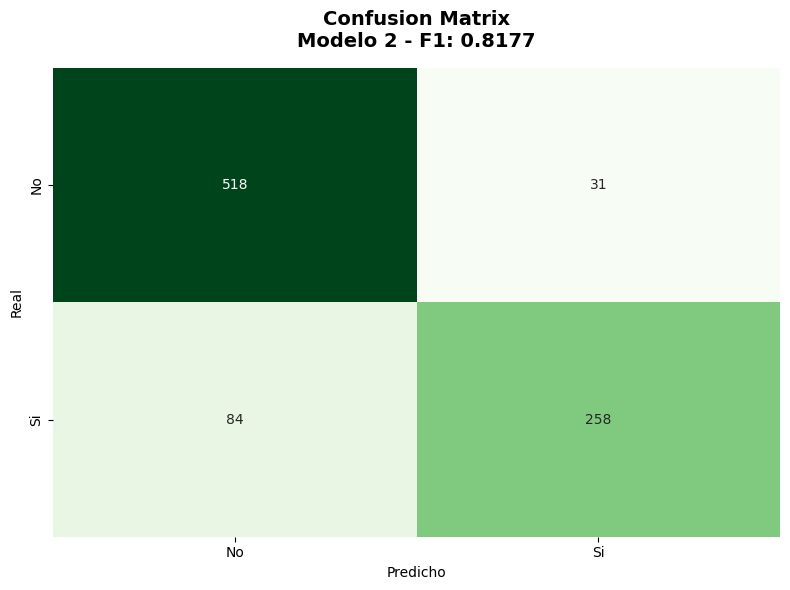


Reporte:
              precision    recall  f1-score   support

          No       0.86      0.94      0.90       549
          Si       0.89      0.75      0.82       342

    accuracy                           0.87       891
   macro avg       0.88      0.85      0.86       891
weighted avg       0.87      0.87      0.87       891



In [73]:
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['No', 'Si'], yticklabels=['No', 'Si'])
plt.title(f'Confusion Matrix\n{mejor} - F1: {f1_final:.4f}', 
          fontsize=14, fontweight='bold', pad=15)
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

print("\nReporte:")
print(classification_report(y, y_pred, target_names=['No', 'Si']))

Predicciones en TEST...
Total: 418
No: 271 (64.8%)
Si: 147 (35.2%)


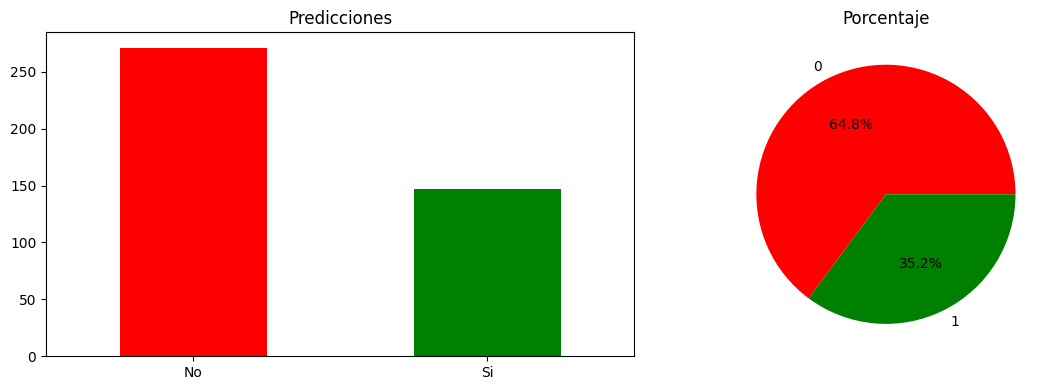

In [74]:
print("Predicciones en TEST...")

y_test_pred = modelo_final.predict(X_test_scaled)

print(f"Total: {len(y_test_pred)}")
print(f"No: {(y_test_pred==0).sum()} ({(y_test_pred==0).sum()/len(y_test_pred)*100:.1f}%)")
print(f"Si: {(y_test_pred==1).sum()} ({(y_test_pred==1).sum()/len(y_test_pred)*100:.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

pd.Series(y_test_pred).value_counts().plot(kind='bar', ax=axes[0], color=['red', 'green'])
axes[0].set_title('Predicciones', fontsize=12)
axes[0].set_xticklabels(['No', 'Si'], rotation=0)

pd.Series(y_test_pred).value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['red', 'green'])
axes[1].set_title('Porcentaje', fontsize=12)
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

## 9. Exportar

In [75]:
resultado = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': y_test_pred
})

resultado.to_csv('./Titanic/mi_resultado.csv', index=False)

print("="*80)
print("GUARDADO")
print("="*80)
print(f"Archivo: mi_resultado.csv")
print(f"Total: {len(resultado)}")
print(f"\nPrimeras 10:")
print(resultado.head(10))
print(f"\nUltimas 10:")
print(resultado.tail(10))

GUARDADO
Archivo: mi_resultado.csv
Total: 418

Primeras 10:
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
5          897         0
6          898         0
7          899         0
8          900         1
9          901         0

Ultimas 10:
     PassengerId  Survived
408         1300         1
409         1301         1
410         1302         1
411         1303         1
412         1304         0
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1310         1


## 10. Resumen

In [76]:
print("\n" + "="*80)
print(" "*25 + "RESUMEN FINAL")
print("="*80)

print(f"\nDatos: {len(train)} train, {len(test)} test")
print(f"Features: {len(features)}")

print("\nOptimizaciones:")
print("  + Feature engineering avanzado")
print("  + Categorias edad y familia")
print("  + Interacciones importantes")
print("  + Tarifa por persona")
print("  + Deck de cabina")
print("  + Redes profundas")
print("  + Learning rate adaptativo")

print("\nModelos:")
for nombre in modelos.keys():
    print(f"  {nombre}: F1-Clase-1 = {resultados[nombre]['F1-Clase-1']:.4f}")

print(f"\nMejor: {mejor}")
print(f"Arquitectura: {configuraciones[mejor]['hidden_layer_sizes']}")
print(f"F1 Final: {f1_final:.4f}")

print("\n" + "="*80)
print(" "*32 + "COMPLETADO")
print("="*80)


                         RESUMEN FINAL

Datos: 891 train, 418 test
Features: 42

Optimizaciones:
  + Feature engineering avanzado
  + Categorias edad y familia
  + Interacciones importantes
  + Tarifa por persona
  + Deck de cabina
  + Redes profundas
  + Learning rate adaptativo

Modelos:
  Modelo 1: F1-Clase-1 = 0.7429
  Modelo 2: F1-Clase-1 = 0.7442
  Modelo 3: F1-Clase-1 = 0.7031

Mejor: Modelo 2
Arquitectura: (150, 100, 50, 25)
F1 Final: 0.8177

                                COMPLETADO
